In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import validation_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz,export_text, plot_tree
from sklearn.metrics import roc_curve
from sklearn.ensemble import VotingClassifier # voting regressor도 있음

from sklearn.compose import make_column_transformer

plt.rcParams["figure.figsize"] = (36,12)
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False
mpl.rcParams["font.family"]="Malgun Gothic"
mpl.rcParams["axes.unicode_minus"]= False


In [2]:
card_df = pd.read_csv('creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


###  <span style="color:yellow">Raw Data Histogram 확인</span>
- 모든 Feature data(V1~V28)가 0을 기준으로 PCA가 되어있음을 확인. 뚜렷한 상관성을 알아내기 힘듦.
- V11, V15가 비슷한 형태 (특정 히스토그램만 색상 바꿔서 볼 수 있을까요?)
- V18, V19 확인 필요.
- V20, V21, V23 확인 필요.

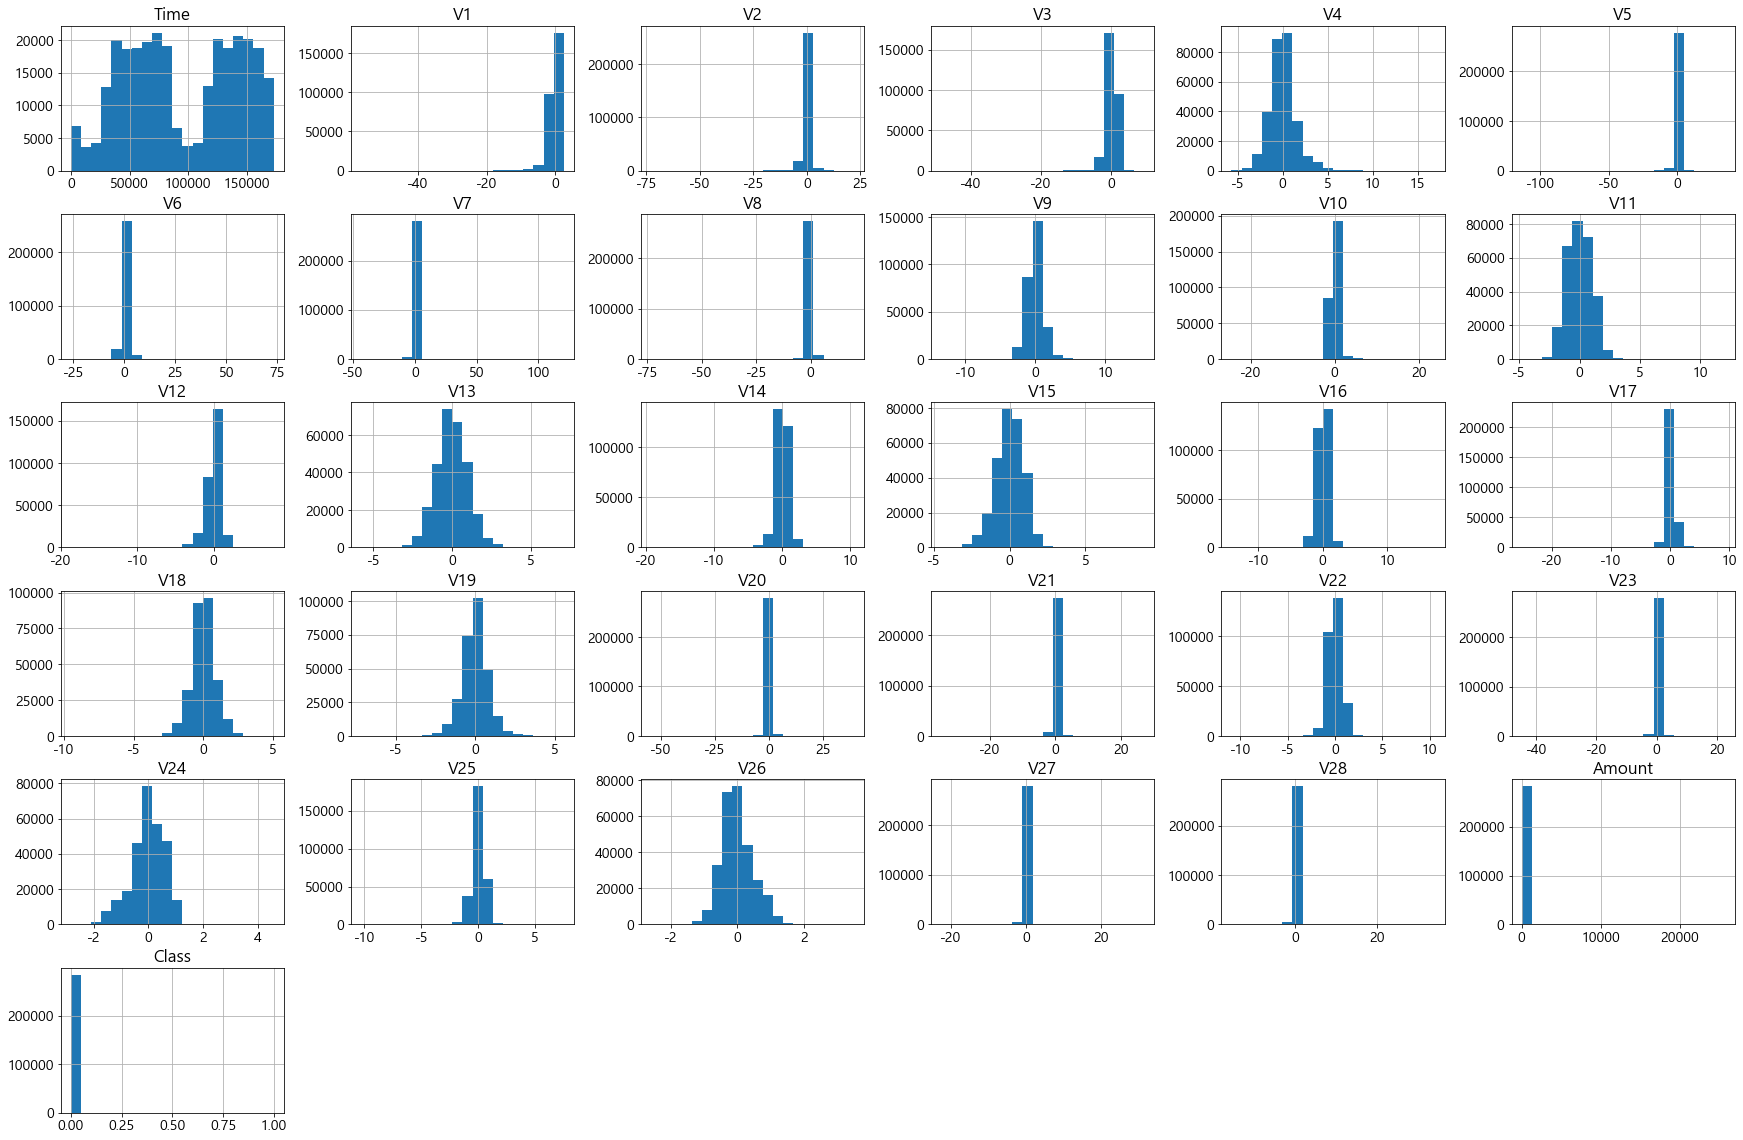

In [3]:
card_df.hist(figsize=(30,20),bins=20)
plt.show()

###  <span style="color:yellow">Raw Data Correlation(상관관계) 확인.</span>
- 유의미한 값은 보이지 않는다.
- Amount와 음의 상관관계 feature값 : V2, V5
- Amount와 양의 상관관계를 가지는 feature값 : V7, V20

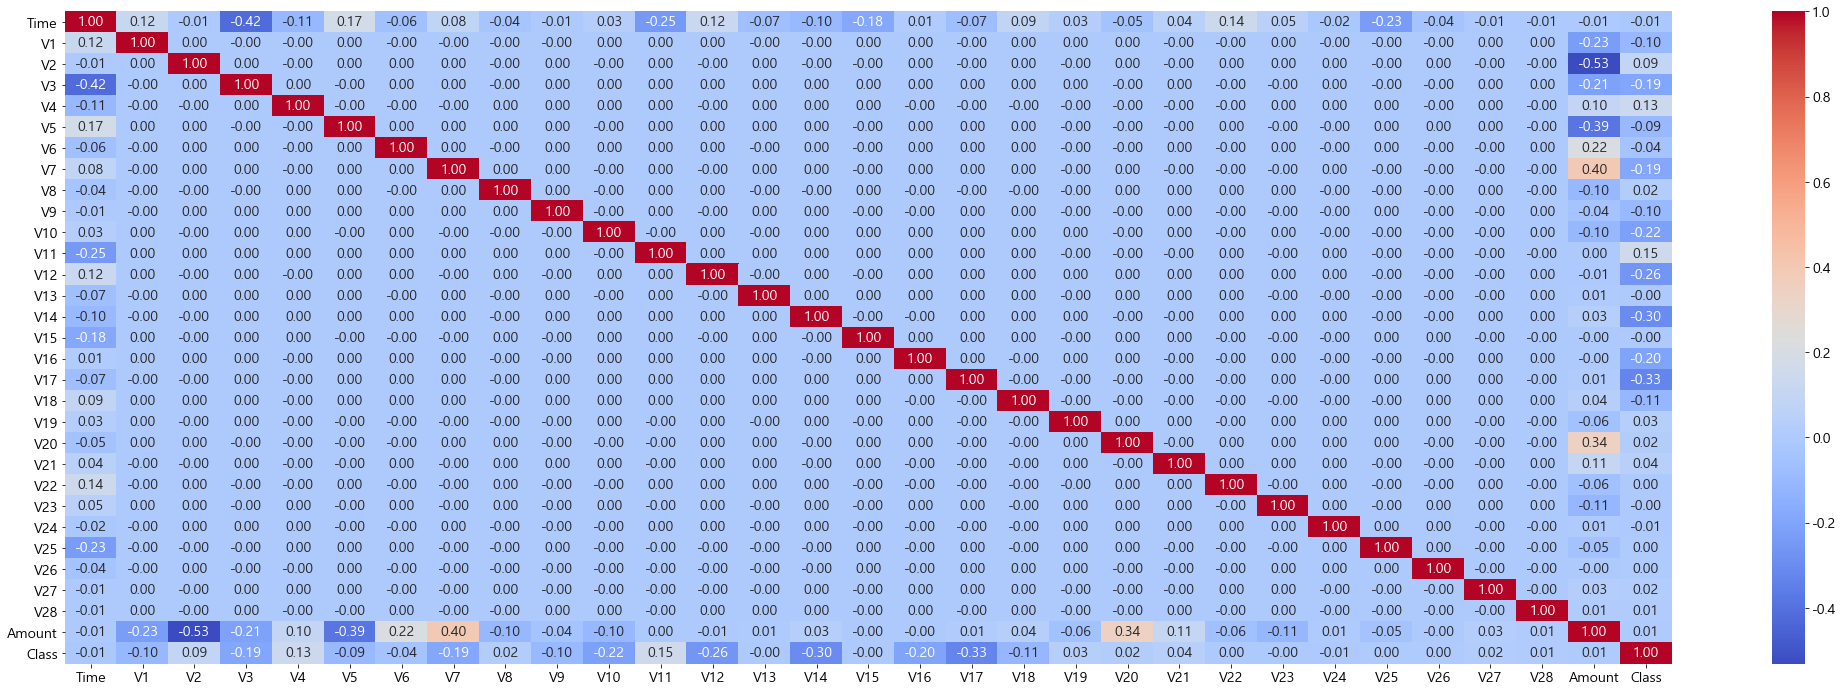

In [4]:
corr = sns.heatmap(card_df[:].corr(), annot=True, fmt='.2f',cmap="coolwarm")

---
## <span style="color:yellow">정상거래(Class 0)의 비율이 월등히 높다.(불균형한 레이블 값)</span>

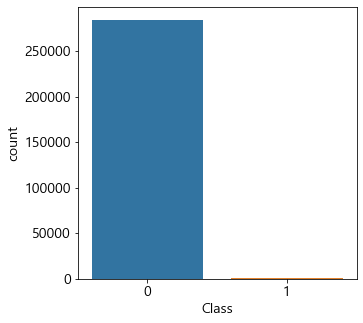

Class 개수 :
 0    284315
1       492
Name: Class, dtype: int64
Class 비율 :
 0    99.827251
1     0.172749
Name: Class, dtype: float64


In [5]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
sns.countplot(data=card_df, x = 'Class')
plt.show()

# Class 개수, 비율
print('Class 개수 :\n', card_df['Class'].value_counts())
print('Class 비율 :\n', card_df['Class'].value_counts() / card_df['Class'].count() * 100)


### Time은 의미없는 열이라고 생각해 삭제하고 진행해보았음.

In [6]:
# 'Time' 삭제
data = card_df.copy()
data.drop('Time', axis=1, inplace=True)
data.head(3)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


---

### Train_Test_Split

In [7]:
x = data.iloc[:,:-1]
y = data.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify=y, random_state=1)

### train data와 test data가 지정한 비율로 나뉘었는지 확인

In [8]:
print('train data, test data')
print(x.shape)
print(y.shape)
print('\n train data, test data 비율')
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print("\n Train 데이터 Class 결과값 :")
print(y_train.value_counts()/y_train.shape[0]*100)
print("\n Test 데이터 Class 결과값 :")
print(y_test.value_counts()/y_test.shape[0]*100)

train data, test data
(284807, 29)
(284807,)

 train data, test data 비율
(227845, 29)
(227845,)
(56962, 29)
(56962,)

 Train 데이터 Class 결과값 :
0    99.827075
1     0.172925
Name: Class, dtype: float64

 Test 데이터 Class 결과값 :
0    99.827955
1     0.172045
Name: Class, dtype: float64


---
## 오차행렬 확인

In [9]:
model = LogisticRegression()
model.fit(x_train, y_train)
y_test_pred = model.predict(x_test)
cm_train = confusion_matrix(y_test, y_test_pred)
cm_train

array([[56851,    13],
       [   29,    69]], dtype=int64)

---
### LogisticRegression Confusion matrix
- 사기거래(Class가 1일 때)의 경우 정밀도는 높으나, 재현율과 f1_score가 비교적 성능이 좋지 않음.

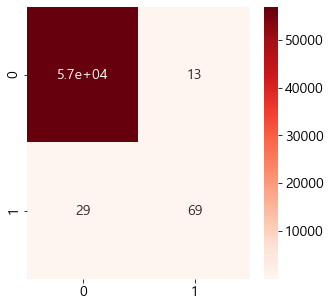

CR               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.70      0.77        98

    accuracy                           1.00     56962
   macro avg       0.92      0.85      0.88     56962
weighted avg       1.00      1.00      1.00     56962



In [10]:
model = make_pipeline(LogisticRegression())
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(1,1,figsize=(5,5))
sns.heatmap(cm, cmap='Reds',annot=True)
plt.show()

print("CR",classification_report(y_test, y_pred))

### StandardScaler(추가), LogisticRegression Confusion Matrix
- 스탠다드 스케일링 후 상대적으로 나은 확률을 보임.

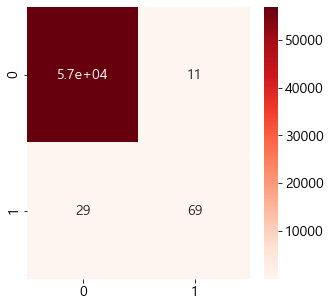

CR               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.70      0.78        98

    accuracy                           1.00     56962
   macro avg       0.93      0.85      0.89     56962
weighted avg       1.00      1.00      1.00     56962



In [11]:
model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(1,1,figsize=(5,5))
sns.heatmap(cm, cmap='Reds',annot=True)
plt.show()

print("CR",classification_report(y_test, y_pred))

### MinMax Scaler, LogisticRegression CM
- 오히려 더 낮은 결과를 보임.

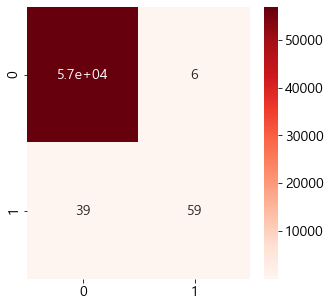

CR               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.91      0.60      0.72        98

    accuracy                           1.00     56962
   macro avg       0.95      0.80      0.86     56962
weighted avg       1.00      1.00      1.00     56962



In [12]:
model = make_pipeline(MinMaxScaler(), LogisticRegression())
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(1,1,figsize=(5,5))
sns.heatmap(cm, cmap='Reds',annot=True)
plt.show()

print("CR",classification_report(y_test, y_pred))

- 지속해서 낮은 재현율을 보임.

---
## <span style="color:yellow">Undersampling(NearMiss) 후 f1_score 비교</span>

In [13]:
from imblearn.under_sampling import NearMiss

NM_model = NearMiss(version=2)

x_train_u, y_train_u = NearMiss().fit_resample(x_train.values, y_train.values)
x_test_u, y_test_u   = NearMiss().fit_resample(x_test.values, y_test.values)

model = LogisticRegression()
model.fit(x_train_u, y_train_u)
y_pred_u = model.predict(x_test_u)
cm = confusion_matrix(y_test_u, y_pred_u)
cm

array([[94,  4],
       [ 1, 97]], dtype=int64)

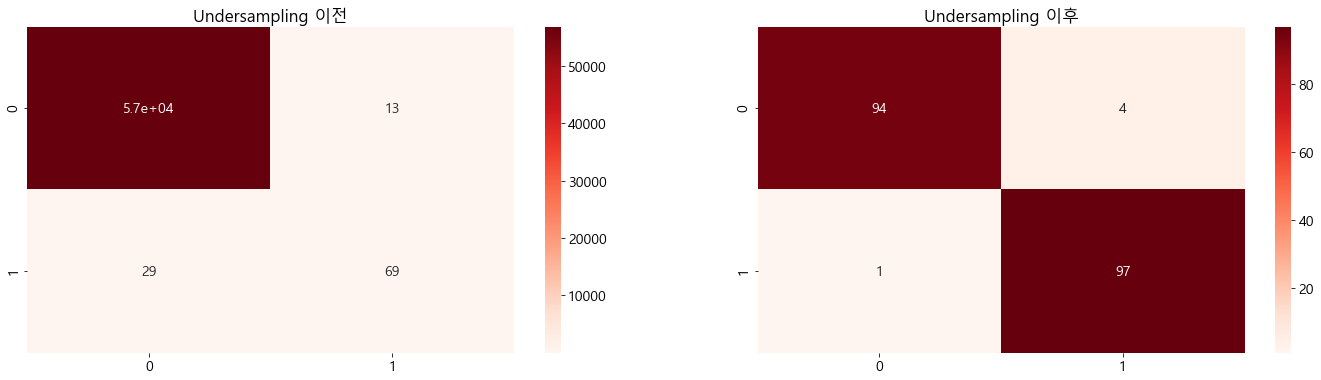

Undersampling 이전
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.70      0.77        98

    accuracy                           1.00     56962
   macro avg       0.92      0.85      0.88     56962
weighted avg       1.00      1.00      1.00     56962


Undersampling 이후
               precision    recall  f1-score   support

           0       0.99      0.96      0.97        98
           1       0.96      0.99      0.97        98

    accuracy                           0.97       196
   macro avg       0.97      0.97      0.97       196
weighted avg       0.97      0.97      0.97       196



In [14]:
fig, ax = plt.subplots(1, 2, figsize=(24,6))

model = make_pipeline(LogisticRegression())
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Reds',annot=True,ax=ax[0])
ax[0].set_title('Undersampling 이전')

model_lr = make_pipeline(LogisticRegression())
model_lr.fit(x_train_u, y_train_u)
y_pred_u_lr = model_lr.predict(x_test_u)
cm_lr = confusion_matrix(y_test_u, y_pred_u_lr)
sns.heatmap(cm_lr, cmap='Reds',annot=True,ax=ax[1])
ax[1].set_title('Undersampling 이후')
plt.show()
print('Undersampling 이전\n',classification_report(y_test, y_pred))
print("\nUndersampling 이후\n",classification_report(y_test_u, y_pred_u))

## Corr() Undersampling 후 x_train 상관관계 확인

In [15]:
x_train_df=pd.DataFrame(x_train_u)
# y_trian_df=pd.DataFrame(y_train_u)

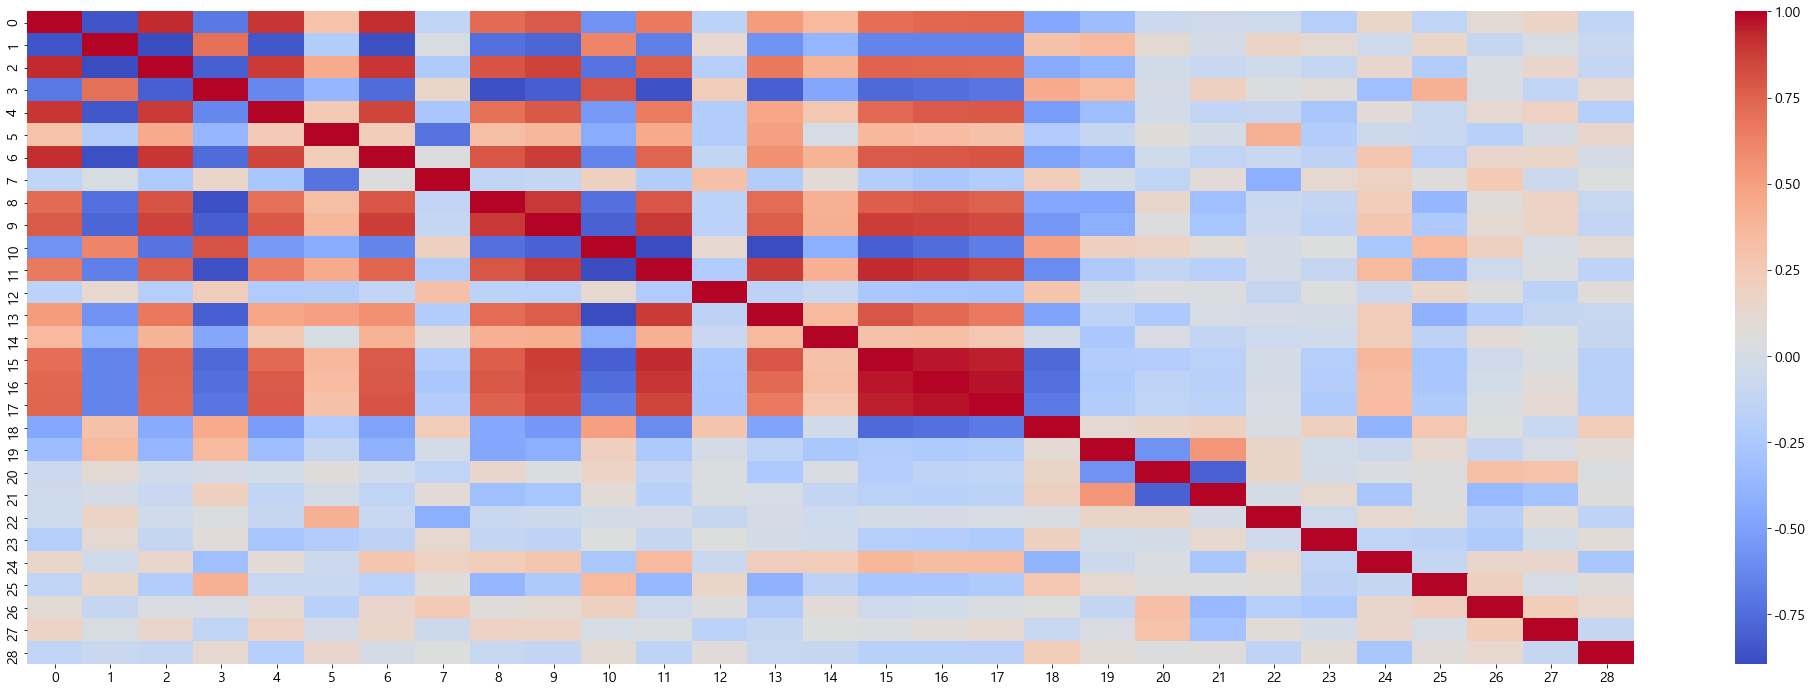

In [16]:
corr = sns.heatmap(x_train_df[:].corr(), cmap="coolwarm")

---
## <span style="color:yellow">Confusion Matrix. 스케일러(Standard, MinMax)에 따른 정밀도, 재현율, f1_score 결과)</span>

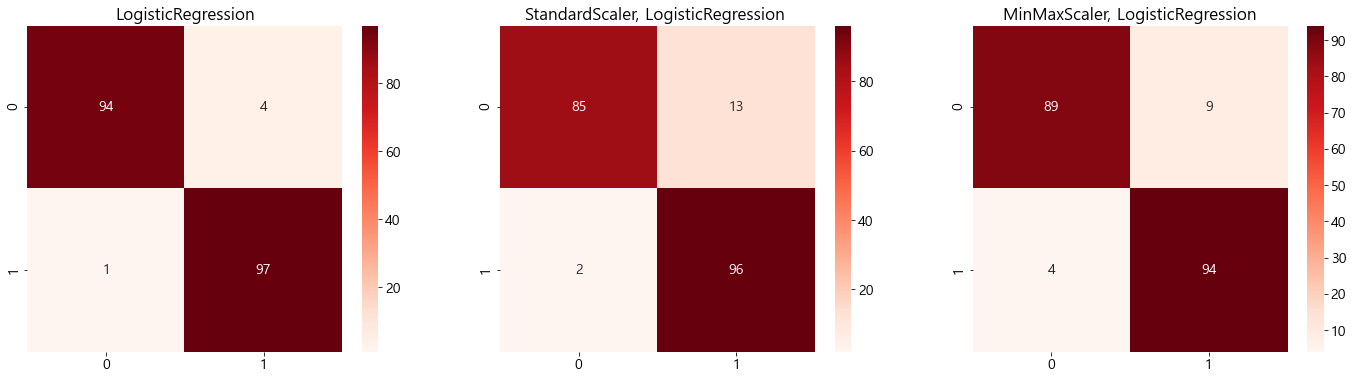

lr               precision    recall  f1-score   support

           0       0.99      0.96      0.97        98
           1       0.96      0.99      0.97        98

    accuracy                           0.97       196
   macro avg       0.97      0.97      0.97       196
weighted avg       0.97      0.97      0.97       196

ss               precision    recall  f1-score   support

           0       0.98      0.87      0.92        98
           1       0.88      0.98      0.93        98

    accuracy                           0.92       196
   macro avg       0.93      0.92      0.92       196
weighted avg       0.93      0.92      0.92       196

mm               precision    recall  f1-score   support

           0       0.96      0.91      0.93        98
           1       0.91      0.96      0.94        98

    accuracy                           0.93       196
   macro avg       0.93      0.93      0.93       196
weighted avg       0.93      0.93      0.93       196



In [17]:
fig, ax = plt.subplots(1, 3, figsize=(24,6))

model_lr = make_pipeline(LogisticRegression())
model_lr.fit(x_train_u, y_train_u)
y_pred_u_lr = model_lr.predict(x_test_u)
cm_lr = confusion_matrix(y_test_u, y_pred_u_lr)
sns.heatmap(cm_lr, cmap='Reds',annot=True,ax=ax[0])
ax[0].set_title('LogisticRegression')
# print(classification_report(y_test_u, y_pred_u))

model_ss_lr = make_pipeline(StandardScaler(),LogisticRegression())
model_ss_lr.fit(x_train_u, y_train_u)
y_pred_u_ss = model_ss_lr.predict(x_test_u)
cm_ss = confusion_matrix(y_test_u, y_pred_u_ss)
sns.heatmap(cm_ss, cmap='Reds',annot=True,ax=ax[1])
ax[1].set_title('StandardScaler, LogisticRegression ')
# print(classification_report(y_test_u, y_pred_u))

model_mm_lr = make_pipeline(MinMaxScaler(), LogisticRegression())
model_mm_lr.fit(x_train_u, y_train_u)
y_pred_u_mm = model_mm_lr.predict(x_test_u)
cm_mm = confusion_matrix(y_test_u, y_pred_u_mm)
sns.heatmap(cm_mm, cmap='Reds',annot=True,ax=ax[2])
ax[2].set_title('MinMaxScaler, LogisticRegression')
plt.show()


print("lr",classification_report(y_test_u, y_pred_u_lr))
print("ss",classification_report(y_test_u, y_pred_u_ss))
print("mm",classification_report(y_test_u, y_pred_u_mm))

- 스케일링을 하지 않았을 때 가장 유의있는 점수 도출.

---
### Tree Model 

In [18]:
model_tree = DecisionTreeClassifier(criterion='entropy')
model_tree.fit(x_train_u, y_train_u)

DecisionTreeClassifier(criterion='entropy')

In [19]:
model_tree.score(x_test_u, y_test_u)

0.8520408163265306

In [20]:
pipe_tree = make_pipeline(DecisionTreeClassifier(criterion='entropy'))

In [21]:
param_range = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]

교차검증

In [22]:
train_score, test_score = validation_curve(estimator=pipe_tree, X=x_train_u,
                 y=y_train_u, param_name='decisiontreeclassifier__max_depth',
                param_range=param_range, scoring='f1_macro',cv=5, verbose=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    0.6s finished


최적의 depth값 = 3

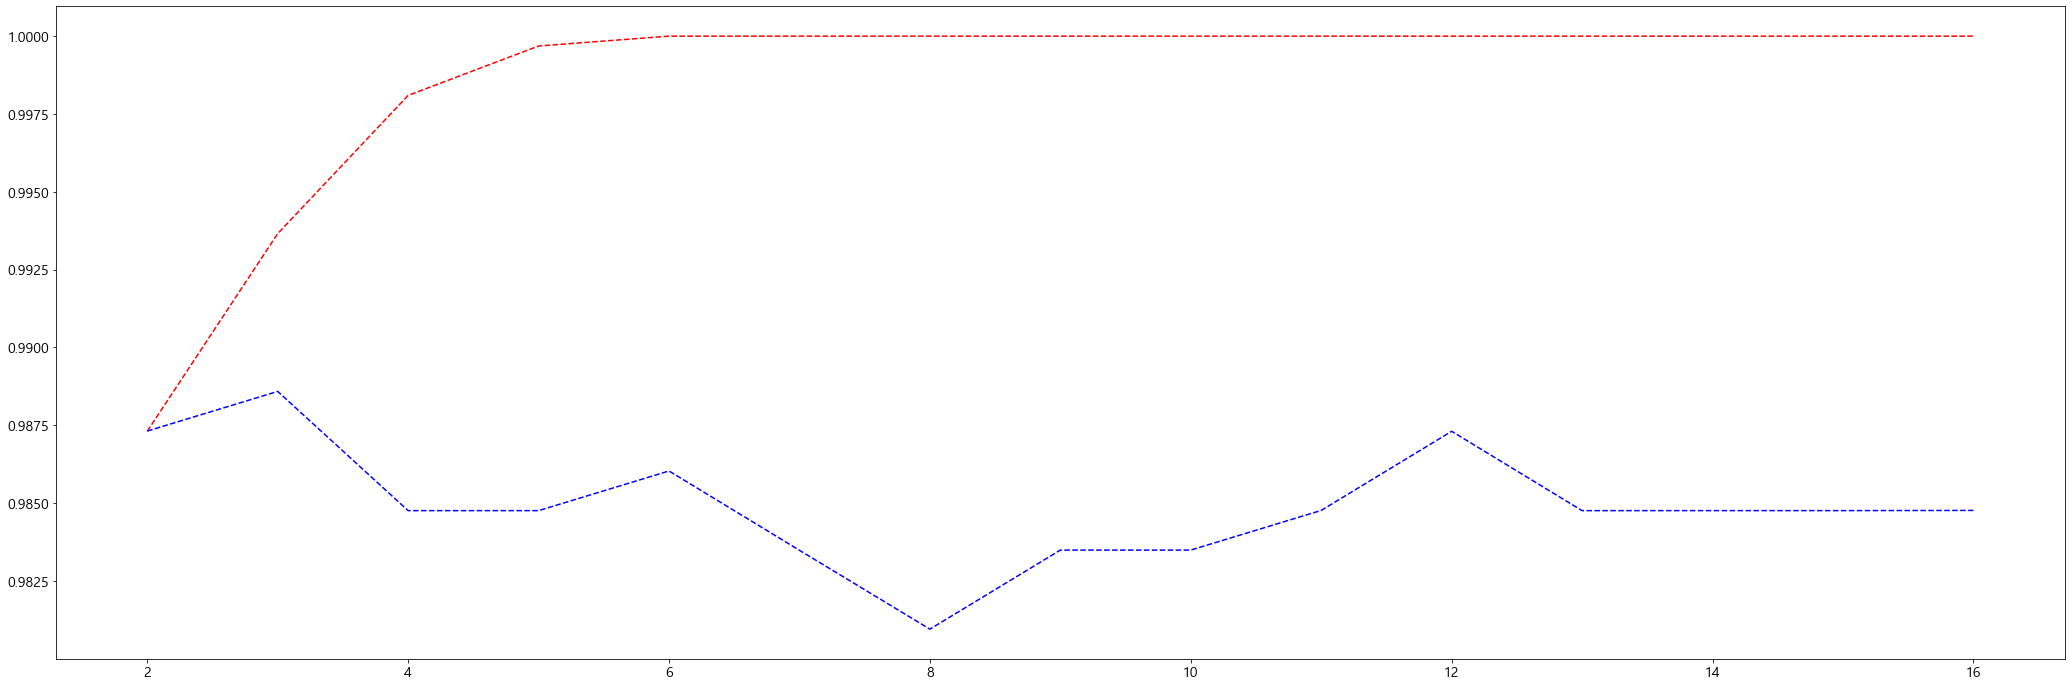

In [23]:
plt.plot(param_range, train_score.mean(axis=1), 'r--')
plt.plot(param_range, test_score.mean(axis=1), 'b--')
plt.show()

---
## <span style="color:yellow">Soft Voting(로지스틱회귀, KNN, 결정트리)</span>

In [24]:
#파이프라인
model_logi = make_pipeline(StandardScaler(), LogisticRegression())
model_knn = make_pipeline(StandardScaler(),KNeighborsClassifier())
model_tree = make_pipeline(StandardScaler(),DecisionTreeClassifier(max_depth=3))
# vote
model_vote = VotingClassifier(estimators=[('logi',model_logi),
                                        ('knn',model_knn),
                                        ('tree',model_tree)])
model_vote.fit(x_train_u, y_train_u)
y_pred_u_vt = model_vote.predict(x_test_u)
# vote.fit
model_vote.fit(x_train_u, y_train_u)
# vote.score
model_vote.score(x_test_u, y_test_u)

print(classification_report(y_test_u, y_pred_u_vt))

              precision    recall  f1-score   support

           0       0.99      0.87      0.92        98
           1       0.88      0.99      0.93        98

    accuracy                           0.93       196
   macro avg       0.94      0.93      0.93       196
weighted avg       0.94      0.93      0.93       196



In [25]:
#파이프라인
model_logi = make_pipeline(MinMaxScaler(), LogisticRegression())
model_knn = make_pipeline(MinMaxScaler(),KNeighborsClassifier())
model_tree = make_pipeline(MinMaxScaler(),DecisionTreeClassifier(max_depth=3))
# vote
model_vote = VotingClassifier(estimators=[('logi',model_logi),
                                        ('knn',model_knn),
                                        ('tree',model_tree)],
                             voting='soft')
model_vote.fit(x_train_u, y_train_u)
y_pred_u_vt2 = model_vote.predict(x_test_u)
# vote.fit
model_vote.fit(x_train_u, y_train_u)
# vote.score
model_vote.score(x_test_u, y_test_u)

print(classification_report(y_test_u, y_pred_u_vt2))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93        98
           1       0.89      0.99      0.94        98

    accuracy                           0.93       196
   macro avg       0.94      0.93      0.93       196
weighted avg       0.94      0.93      0.93       196



Standard Scaler, MinMaxScaler 비교 결과 차이가 없음.

## <span style="color:yellow">가장 성적이 좋았던 모델 model_lr</span>

In [26]:
model_lr = LogisticRegression()
model_lr.fit(x_train_u, y_train_u)

print(classification_report(y_test_u, y_pred_u_lr))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97        98
           1       0.96      0.99      0.97        98

    accuracy                           0.97       196
   macro avg       0.97      0.97      0.97       196
weighted avg       0.97      0.97      0.97       196



---
## <span style="color:yellow">Model_lr ROC Curve 비교</span>

In [27]:
x_train_df=pd.DataFrame(x_train_u)
# y_trian_df=pd.DataFrame(y_train_u)

In [28]:
display(x_train_df.head(3))

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,1.204831,1.283588,-1.605282,1.593744,1.060023,-1.351950,0.727037,-0.272017,-0.513909,-1.606672,...,-0.041561,-0.177961,-0.356453,-0.183841,-0.239390,0.798794,-0.265957,0.059183,0.094458,1.00
1,1.182183,1.299576,-1.466766,1.669216,0.909958,-1.536089,0.740337,-0.298284,-0.550703,-1.609908,...,-0.046205,-0.155518,-0.288590,-0.144640,0.089351,0.758616,-0.286459,0.060256,0.097947,0.89
2,1.220356,0.580348,-0.382916,1.282871,0.371223,-0.376870,0.100192,-0.020650,0.007137,-0.572344,...,-0.141245,-0.021869,0.031405,-0.158519,-0.558891,0.658358,-0.217684,0.050580,0.044972,1.00


In [29]:
model_lr = make_pipeline(StandardScaler(), LogisticRegression())
model_lr.fit(x_train_u, y_train_u)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [30]:
p = model_lr.predict_proba(x_test)

q = model_lr.predict_proba(x_test_u)

In [31]:
df = pd.DataFrame([y_test])
df = df.T
df

df_u = pd.DataFrame([y_test_u])
df_u = df_u.T
df_u

df['proba'] = p[:,1]
df

df_u['proba'] = q[:,1]
df_u

df.sort_values(by='proba')

df_u.sort_values(by='proba')

,0,proba
84,0,0.028891
89,0,0.029250
82,0,0.029272
72,0,0.030026
73,0,0.030055
...,...,...
121,1,1.000000
187,1,1.000000
131,1,1.000000
193,1,1.000000


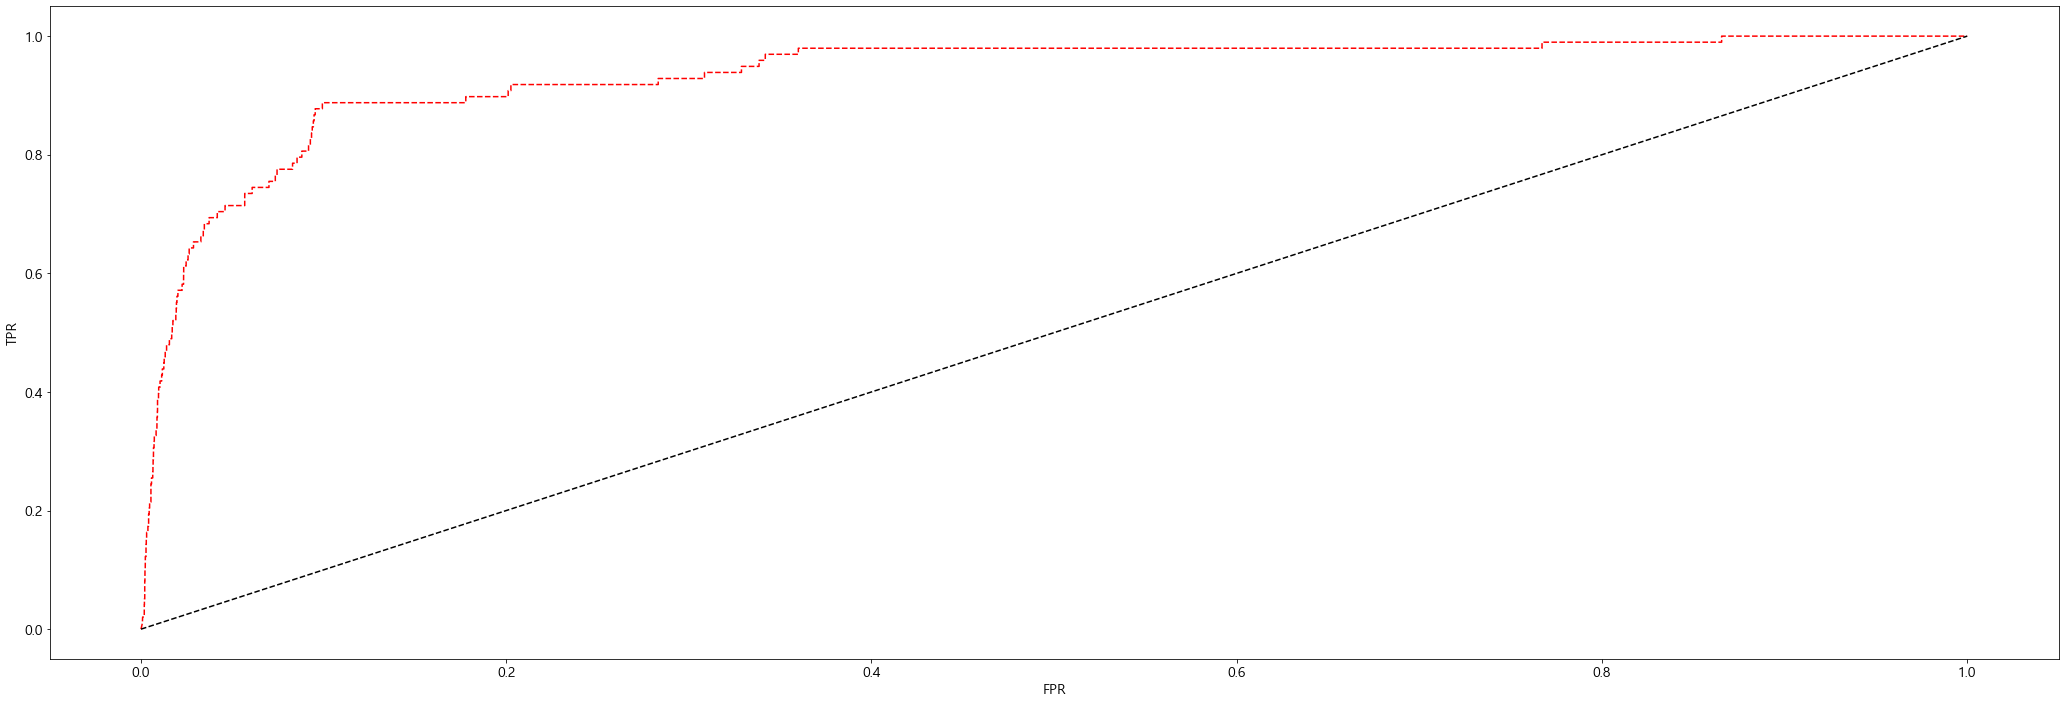

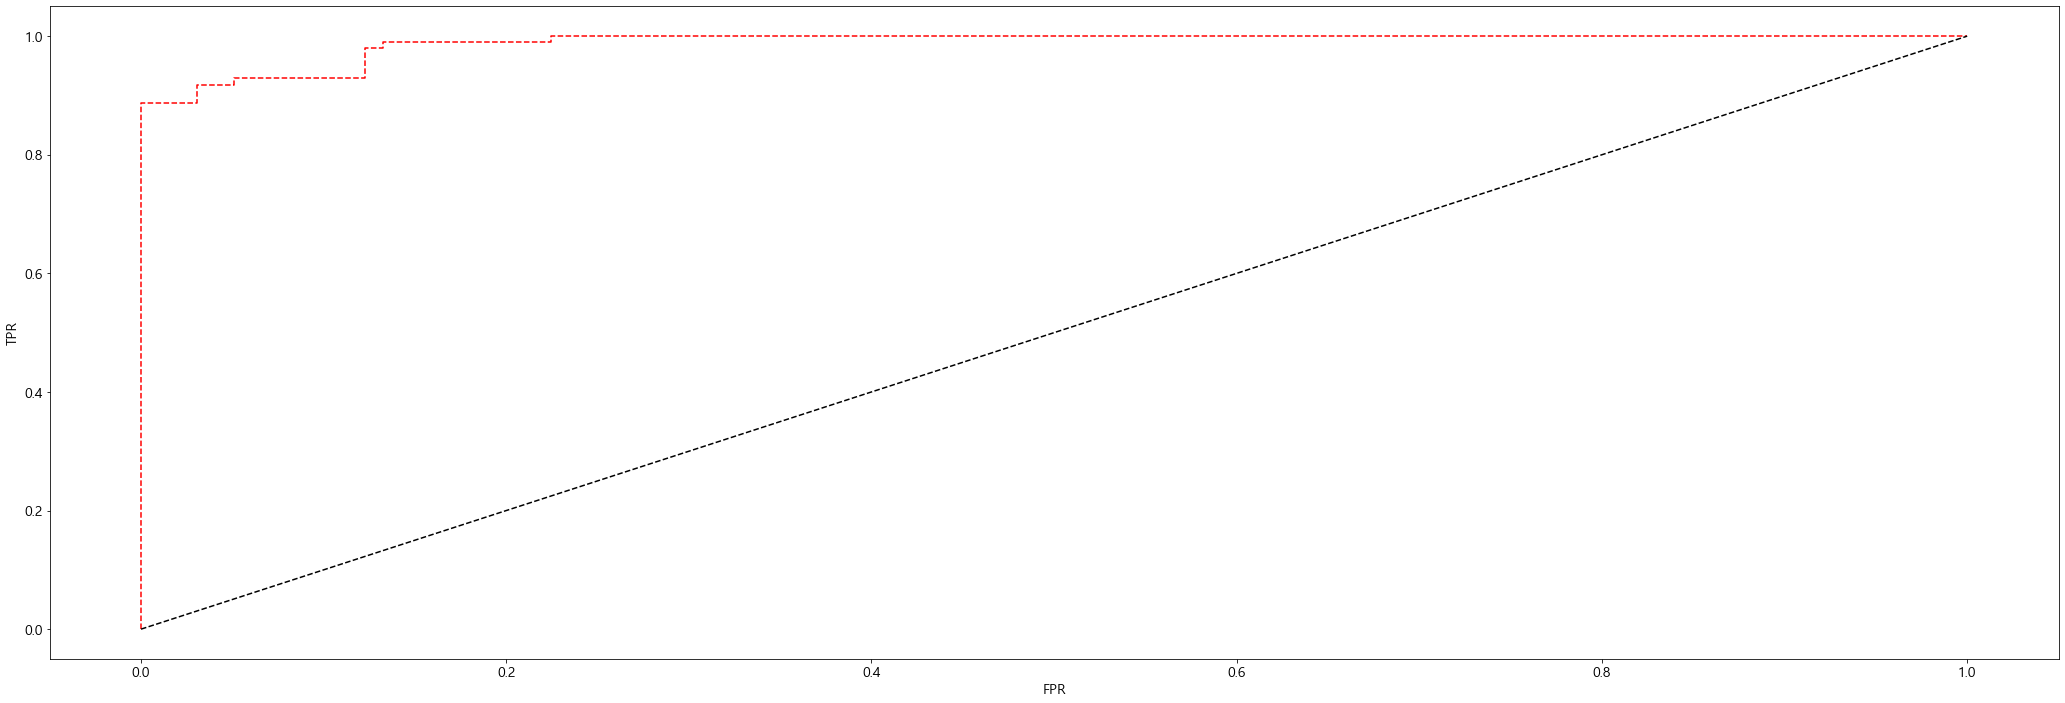

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, df['proba'].values)
plt.plot(fpr, tpr, 'r--')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test_u, df_u['proba'].values)
plt.plot(fpr, tpr, 'r--')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

---